# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.21KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

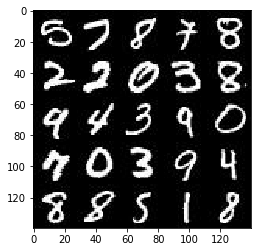

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

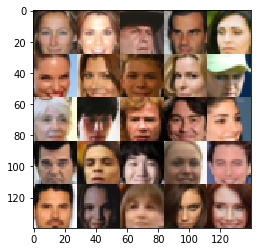

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, 0.7)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, 0.7)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.contrib.layers.dropout(x3, 0.5)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        #First fully connected layer
        x1 = tf.layers.dense(z, 4*4*1024)
        x1 = tf.reshape(x1, (-1, 4, 4, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        #x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, 0.9)
        # 4x4x1024
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        #x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, 0.9)
        # 4x4x512
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        #x2 = tf.nn.dropout(x2, 0.9)
        # 7x7x256
        #print(x3.shape)
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.contrib.layers.dropout(x4, 0.6, is_training=is_train)
        # 14x14x128
        #print(x4.shape)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=None)
        # 28x28xout_channel_dim
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Resize images from -1 to 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = tf.contrib.distributions.Gaussian(mu=0, sigma=3)
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
            show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
            print('Done');

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3649... Generator Loss: 0.2644
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 1.7800
Epoch 1/2... Discriminator Loss: 0.5392... Generator Loss: 2.4447
Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 2.3796
Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 2.2131
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 1.9346
Epoch 1/2... Discriminator Loss: 2.8540... Generator Loss: 1.2546
Epoch 1/2... Discriminator Loss: 3.2446... Generator Loss: 0.1241
Epoch 1/2... Discriminator Loss: 2.0297... Generator Loss: 0.4623


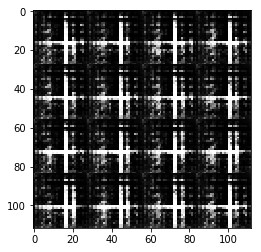

Epoch 1/2... Discriminator Loss: 2.0843... Generator Loss: 0.4213
Epoch 1/2... Discriminator Loss: 1.7203... Generator Loss: 0.6350
Epoch 1/2... Discriminator Loss: 2.2047... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.9175... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 1.9204... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.8501
Epoch 1/2... Discriminator Loss: 1.8607... Generator Loss: 1.0804


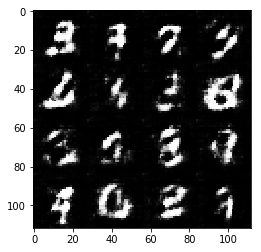

Epoch 1/2... Discriminator Loss: 1.5765... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 1.5748... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 1.2461
Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 1.4639
Epoch 1/2... Discriminator Loss: 1.5046... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.6051


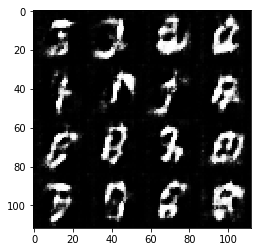

Epoch 1/2... Discriminator Loss: 1.8466... Generator Loss: 1.5163
Epoch 1/2... Discriminator Loss: 1.6051... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.5101... Generator Loss: 0.5106
Epoch 1/2... Discriminator Loss: 1.9985... Generator Loss: 0.5258
Epoch 1/2... Discriminator Loss: 1.7940... Generator Loss: 1.1426
Epoch 1/2... Discriminator Loss: 1.5514... Generator Loss: 0.5919
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 1.6107... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.8031... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.7271... Generator Loss: 0.5756


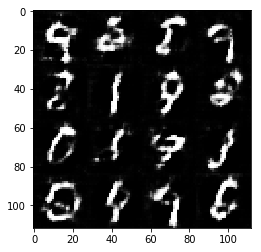

Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.7636... Generator Loss: 0.6822
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.7997
Epoch 1/2... Discriminator Loss: 1.6329... Generator Loss: 0.4988
Epoch 1/2... Discriminator Loss: 1.5125... Generator Loss: 0.9603
Epoch 1/2... Discriminator Loss: 1.7823... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.3216... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.4910... Generator Loss: 0.6460
Epoch 1/2... Discriminator Loss: 1.6388... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 1.6152... Generator Loss: 0.8691


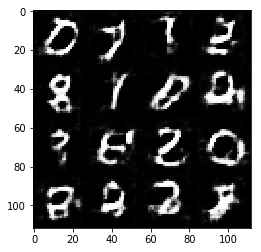

Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.7681... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 2.1822... Generator Loss: 0.4603
Epoch 1/2... Discriminator Loss: 1.6750... Generator Loss: 0.6054
Epoch 1/2... Discriminator Loss: 1.7748... Generator Loss: 0.4822
Epoch 1/2... Discriminator Loss: 1.5923... Generator Loss: 0.6941
Epoch 1/2... Discriminator Loss: 1.7198... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 1.5555... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.5479
Epoch 1/2... Discriminator Loss: 1.7422... Generator Loss: 0.8569


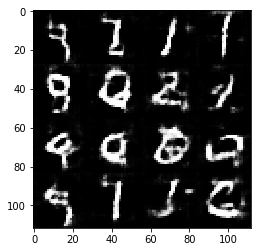

Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.5681... Generator Loss: 0.5594
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 1.6031... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.5692... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.5379... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.7936... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 0.5402
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.7176


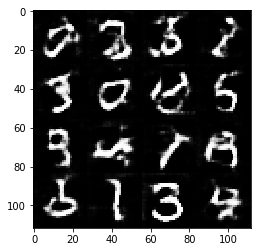

Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.9641
Epoch 1/2... Discriminator Loss: 1.6598... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 1.0280
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.8543
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.9269


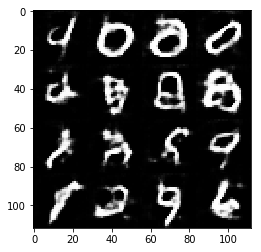

Epoch 1/2... Discriminator Loss: 1.6494... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 1.5692... Generator Loss: 0.9482
Epoch 1/2... Discriminator Loss: 1.3227... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.9199
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.5304... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.6313... Generator Loss: 0.7084


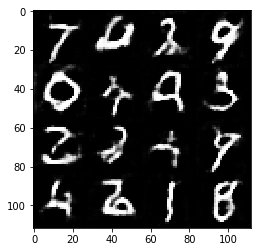

Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.5356... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.9276
Epoch 1/2... Discriminator Loss: 1.6260... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.5578... Generator Loss: 0.7203


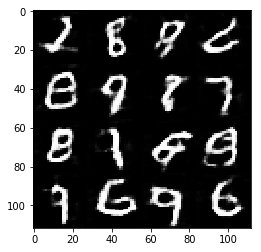

Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.8291
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.5852... Generator Loss: 0.6526
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.5334... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.7119... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.4519... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.7821


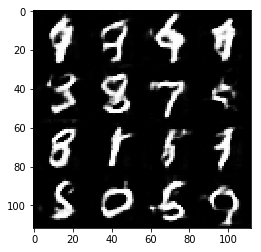

Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 1.0141
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 1.0005
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.5663... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 1.4904... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.7894


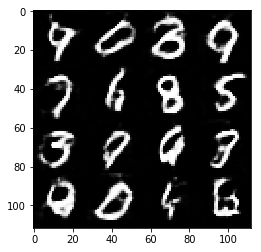

Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.9030
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.9766
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.8955
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 1.5418... Generator Loss: 0.6302


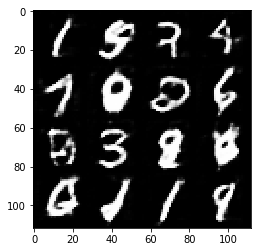

Epoch 1/2... Discriminator Loss: 1.5518... Generator Loss: 0.8693
Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.9073
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.5737... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.8737


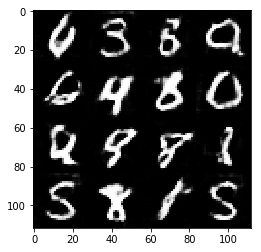

Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 1.5450... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.7068... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 1.0160
Epoch 1/2... Discriminator Loss: 1.6488... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.7474... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.6443


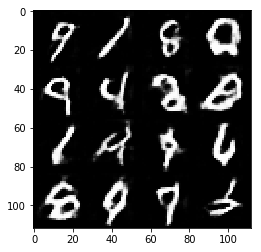

Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.5377... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 1.0323
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 1.4302... Generator Loss: 0.9353
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.7054


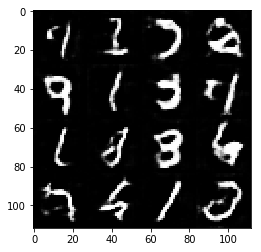

Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.6875... Generator Loss: 0.4588
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 1.0059
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.8874


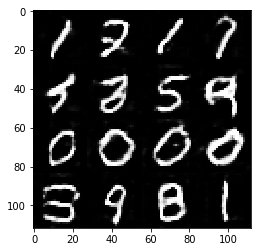

Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7738
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 0.5939
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.7738
Epoch 1/2... Discriminator Loss: 1.4925... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.8922


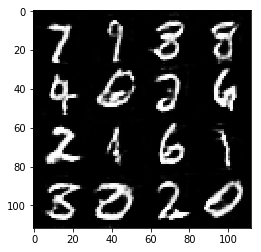

Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.4701... Generator Loss: 0.6511


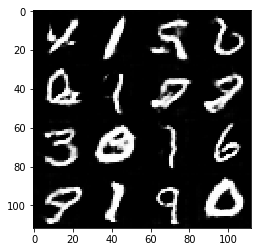

Done
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.9215
Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.8725


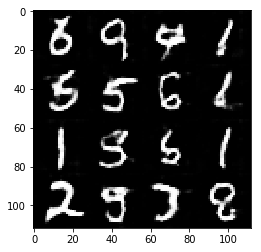

Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 1.2131
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.5749
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 1.5172... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.8306
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.8450
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.6618


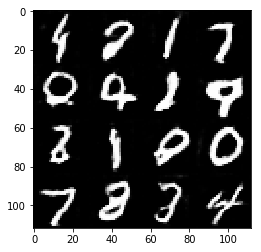

Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 1.1967
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 0.6982
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 1.1475


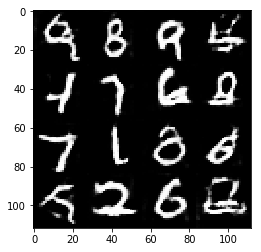

Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.8568
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.8805
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.9838
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.8687


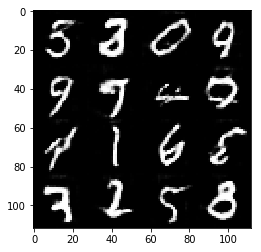

Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 1.2277
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.6068
Epoch 2/2... Discriminator Loss: 1.3365... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 1.1192
Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.8414


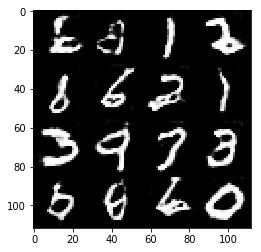

Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.6847
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.9072
Epoch 2/2... Discriminator Loss: 1.4394... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.5637
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.9407
Epoch 2/2... Discriminator Loss: 1.4711... Generator Loss: 0.7145
Epoch 2/2... Discriminator Loss: 1.5714... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.8508


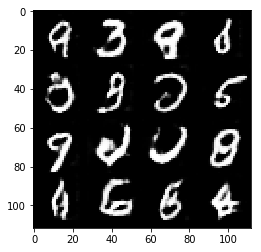

Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 0.9434
Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.6066... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.7452


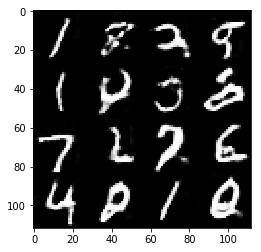

Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 1.7243
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.6335
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.8359
Epoch 2/2... Discriminator Loss: 1.2714... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.5876
Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 1.2482
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 1.2397... Generator Loss: 0.9027


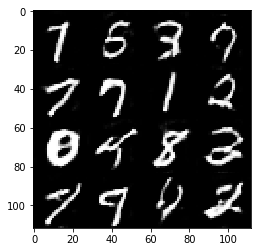

Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 1.4569... Generator Loss: 0.6773
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 1.2820
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 1.1021
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 1.5268... Generator Loss: 0.5957


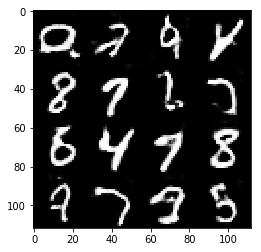

Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.7952
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.9950
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 1.2945
Epoch 2/2... Discriminator Loss: 1.5691... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 1.1776... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 1.2963


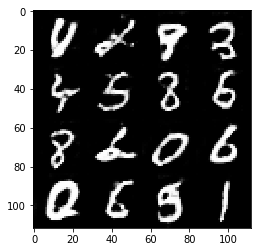

Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.6992
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.9994
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 1.3007
Epoch 2/2... Discriminator Loss: 1.4785... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 0.9253
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.7873


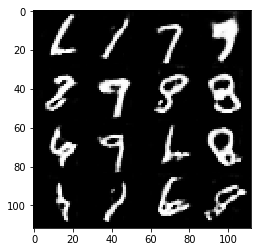

Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 1.1048
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.5921
Epoch 2/2... Discriminator Loss: 1.1636... Generator Loss: 0.9720
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.8569
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 1.0580
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.9556


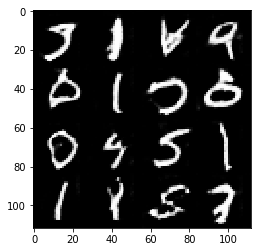

Epoch 2/2... Discriminator Loss: 1.2685... Generator Loss: 0.6467
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.5035... Generator Loss: 0.8162
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 1.0884
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.9550
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.9051
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 1.1806


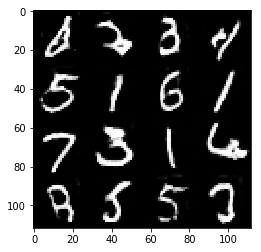

Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.4598
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.9868
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 1.3301
Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.9360
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 1.1194


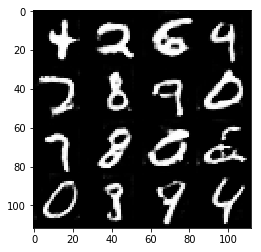

Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 1.0434
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 1.0299
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 1.4071... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.4571
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.8626


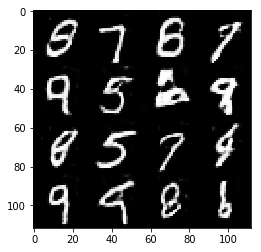

Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 1.4903
Epoch 2/2... Discriminator Loss: 1.5188... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 1.0525
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 1.1233... Generator Loss: 1.0551
Epoch 2/2... Discriminator Loss: 1.7393... Generator Loss: 0.4616
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.9600


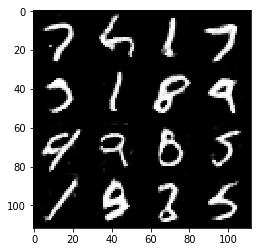

Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 1.1468
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.5718... Generator Loss: 0.3934
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.9104


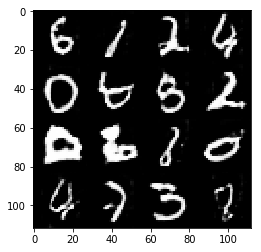

Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 1.0548
Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 0.8581
Epoch 2/2... Discriminator Loss: 1.5161... Generator Loss: 0.4580
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.8337
Epoch 2/2... Discriminator Loss: 1.1409... Generator Loss: 0.9778
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 1.2489
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.9558
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.7145


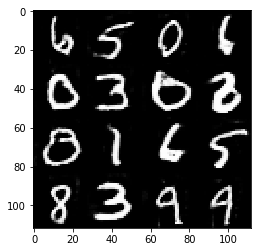

Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 1.0084
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 1.0876
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.9576
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.9087
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 1.0802
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 1.2363
Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 1.0630


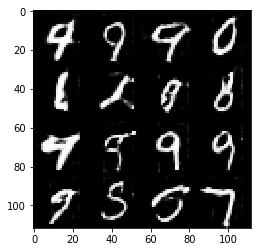

Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 1.1282... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.9276


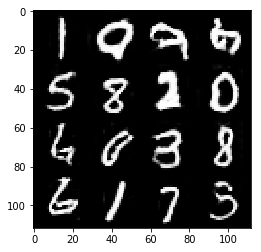

Done


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3004... Generator Loss: 0.2540
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 2.8080
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 2.1156
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 3.6791
Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 2.4150
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 3.2875
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.7947


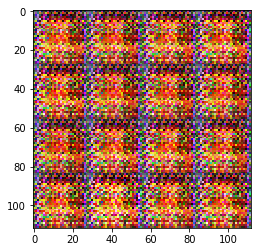

Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 2.9033
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 2.6608
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.3258
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.8743... Generator Loss: 7.1452
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 2.3166
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 2.0146
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 2.1480


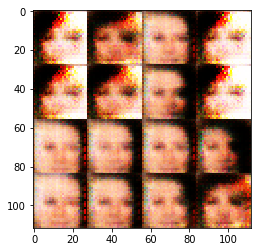

Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 2.1711... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 2.0064... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.7687... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 2.0549... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 1.7147... Generator Loss: 0.8899


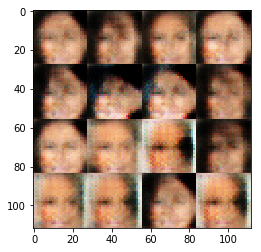

Epoch 1/1... Discriminator Loss: 2.0813... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.8459... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.7171... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 1.2563


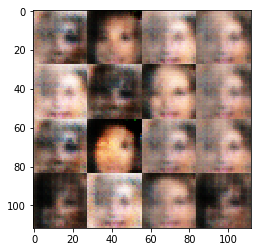

Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.7951... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 2.0222... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.6669... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.5545


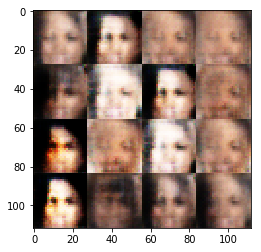

Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.6609... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 1.6907... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.9109


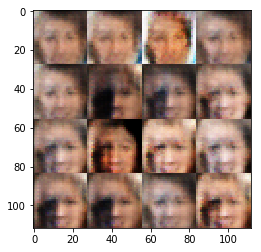

Epoch 1/1... Discriminator Loss: 2.0178... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.9368... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.8009... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.7640... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.6674... Generator Loss: 0.8928


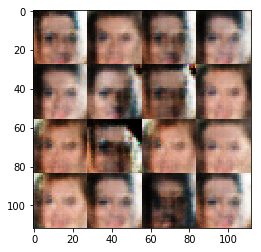

Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.6233... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.6141... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.0578


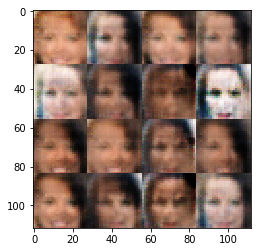

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.6346... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.6191... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.6117... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.8207


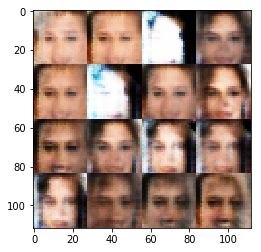

Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.6731... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.8619


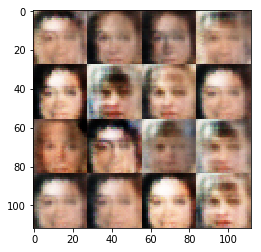

Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.6641... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.7548


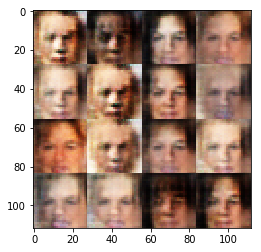

Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 0.7018


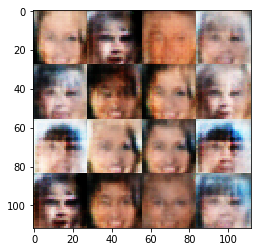

Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.8399


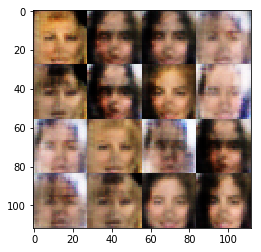

Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.8046


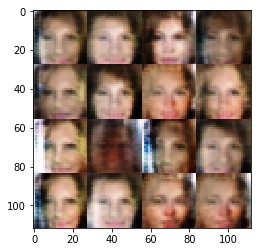

Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7102


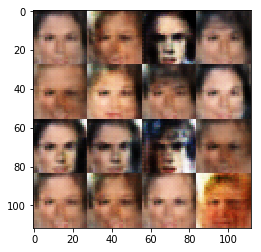

Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.6493... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.8876


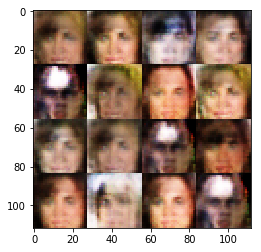

Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.8117


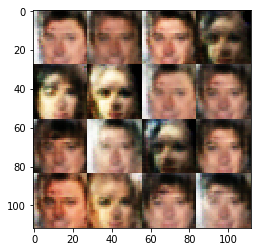

Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7503


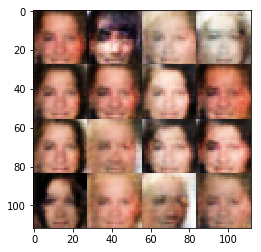

Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.8753


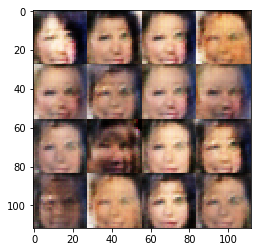

Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7512


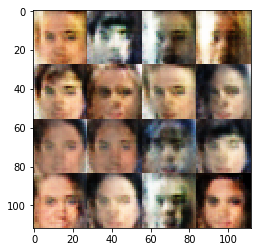

Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7821


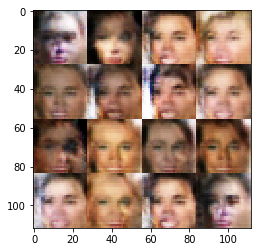

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.9087


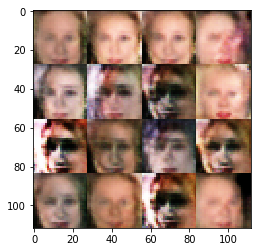

Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.8150


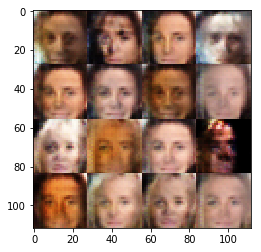

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8705


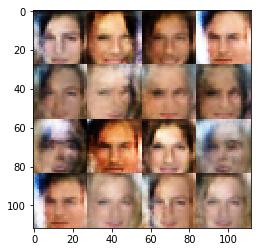

Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.7797


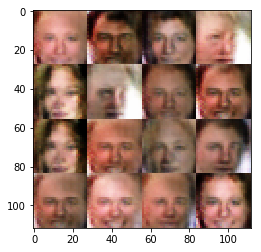

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.8410


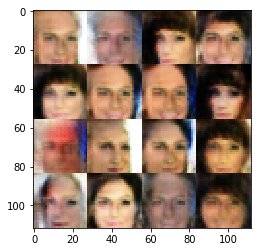

Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.8167


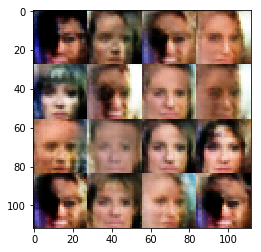

Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8230


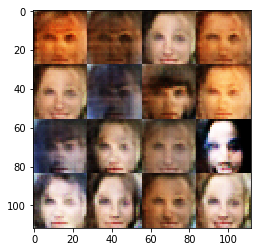

Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8286


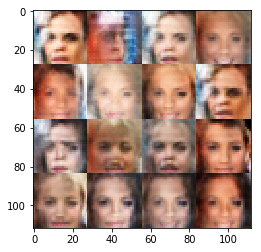

Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.7112


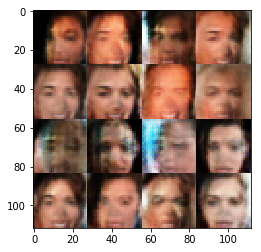

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.7951


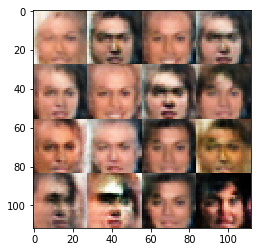

Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7817


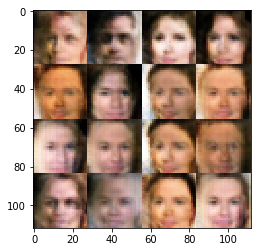

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7694


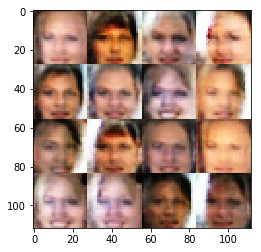

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.7914


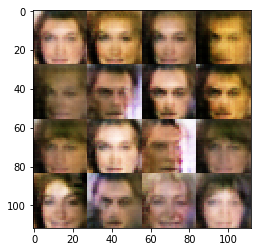

Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7989


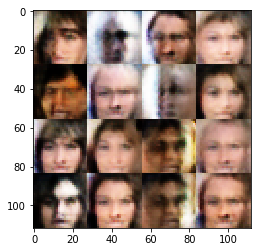

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7763


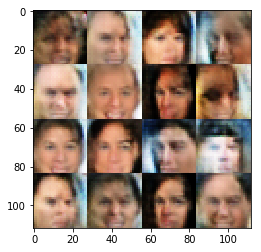

Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7679


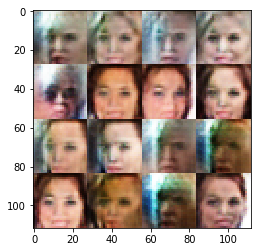

Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.8044


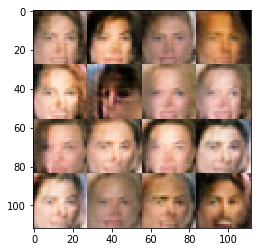

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7828


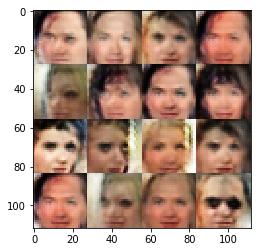

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7563


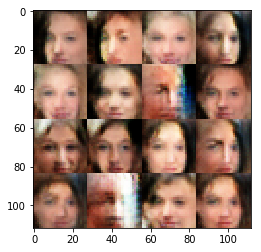

Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7764


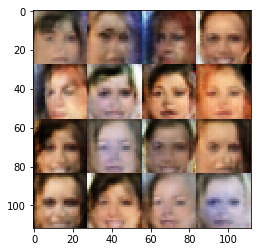

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.8358


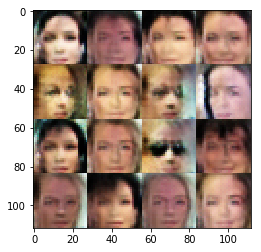

Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7972


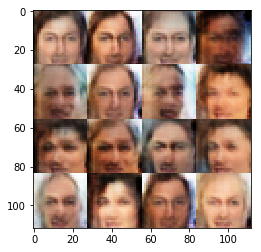

Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7370


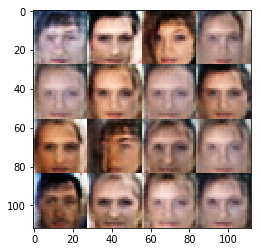

Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7468


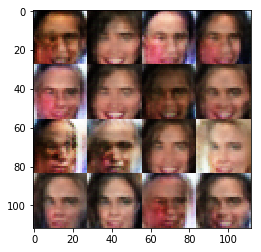

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7768


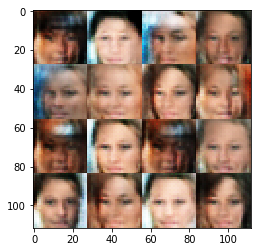

Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7640


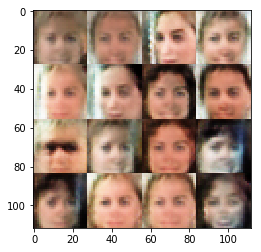

Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7553


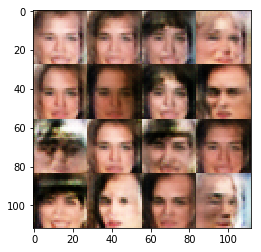

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8183


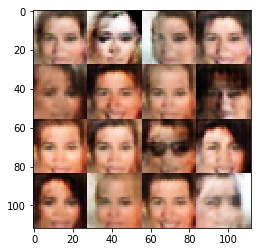

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7595


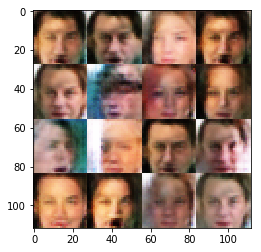

Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.8141


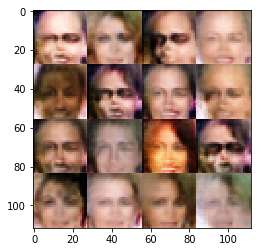

Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.8281


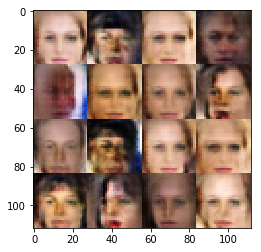

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7626


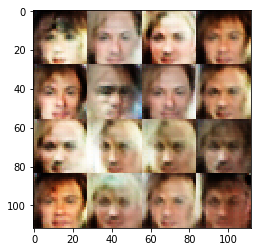

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7792


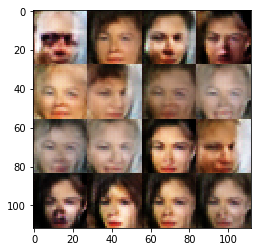

Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7819


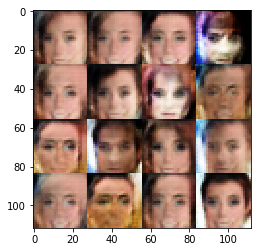

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8301


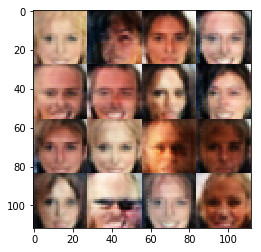

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7365


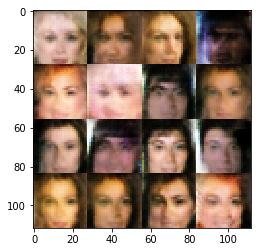

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7291


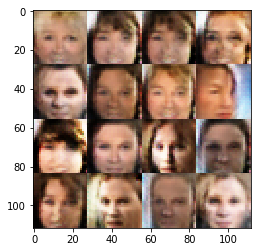

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8289


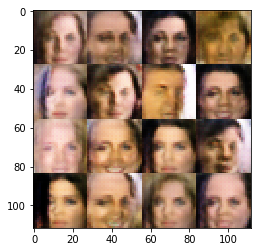

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7363


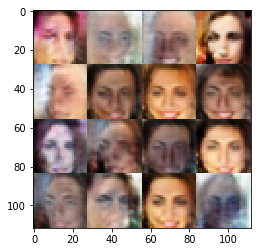

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7748


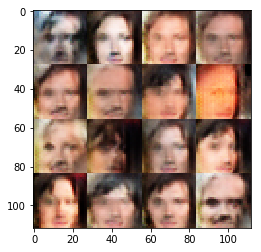

Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7614


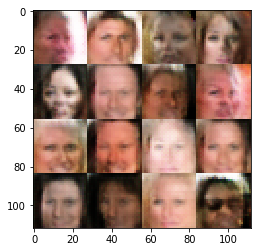

Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7618


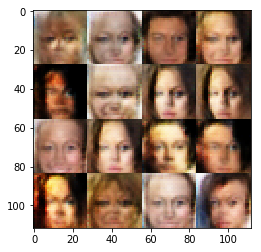

Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7813


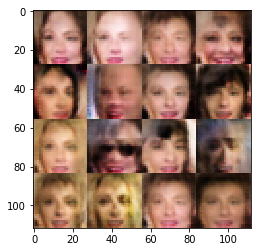

Done


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.